In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from functools import partial
from multiprocessing import Pool, cpu_count
import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from optimization.optimization import LinearRegression, train_model, normal_eq_lr
from optimization.datasets import sim_linear_model

## Simulations

The goal of these simulations is to create cases where we have n samples (could be low or high) and m features (1-1000). In the context of an optimization problem, compare the performance between SGD, Newton's method, and Quasi-Newton for each case.

In [2]:
# Functions for saving/loading results
def save_data(n, n_sim, n_epochs):
    file = '../results/sim_data_'+str(n)+'-obs_'+str(n_sim)+'-sims_'+str(n_epochs)+'-epochs.npz'
    np.savez(file, beta_mse=beta_mse, elapsed_time=elapsed_time,loss_history = loss_history)
    
def load_data(fname):
    data = np.load(fname, allow_pickle=True)
    return data['beta_mse'], data['elapsed_time'], data['loss_history']

# Functions for executing simulations in parallel
def parallel_func(seed, n=None, m=None, n_epochs=None, tol=None, tol_abs=None):
    
    # Generate new data
    X, b, y = sim_linear_model(n, m, seed=seed)

    # Normal equation
    start = time.time()
    b_normal = normal_eq_lr(X, y)[:, 0]
    end = time.time()

    beta_mse_normal = float(((b_normal-b)**2).mean())
    elapsed_time_normal = end-start

    # SGD
    b_hat_sgd, loss_hist_sgd, elapsed_sgd =  train_model(
        X, y, method='sgd', n_epochs=n_epochs, seed=seed, tol=tol, tol_abs=tol_abs)

    beta_mse_sgd = float(((b-b_hat_sgd)**2).mean())

    # Newton's method
    b_hat_newton, loss_hist_newton, elapsed_newton = train_model(
        X, y, method='newton', n_epochs=n_epochs, seed=seed, tol=tol, tol_abs=tol_abs)

    beta_mse_newton = float(((b - b_hat_newton)**2).mean())

    # LBFGS
    b_hat_lbfgs, loss_hist_lbfgs, elapsed_lbfgs = train_model(
        X, y, method='lbfgs', n_epochs=n_epochs, seed=seed, tol=tol, tol_abs=tol_abs)

    beta_mse_lbfgs = float(((b - b_hat_lbfgs)**2).mean())

    results = [
        beta_mse_normal, elapsed_time_normal,
        beta_mse_sgd, loss_hist_sgd, elapsed_sgd,
        beta_mse_newton, loss_hist_newton, elapsed_newton,
        beta_mse_lbfgs, loss_hist_lbfgs, elapsed_lbfgs
    ]

    return results

In [3]:
# Number of simulations
n_sim = 100 

# Number of observations
n_obs = [1000, 5000]

# Number of features
ms = [1, 10, 100, 1000] 

# Number of epochs
n_epochs = 250
tol = 1e-6
seeds = np.arange(n_sim)

In [ ]:
for n in n_obs:

    # Track loss, beta error, and elapsed time
    loss_history = {
        'sgd': np.zeros((len(ms), n_sim, n_epochs)),
        'newton': np.zeros((len(ms), n_sim, n_epochs)),
        'lbfgs': np.zeros((len(ms), n_sim, n_epochs))
    }

    beta_mse = {
        'normal': np.zeros((len(ms), n_sim)),
        'sgd': np.zeros((len(ms), n_sim)),
        'newton': np.zeros((len(ms), n_sim)),
        'lbfgs': np.zeros((len(ms), n_sim))
    }

    elapsed_time = {
        'normal': np.zeros((len(ms), n_sim)),
        'sgd': np.zeros((len(ms), n_sim)),
        'newton': np.zeros((len(ms), n_sim)),
        'lbfgs': np.zeros((len(ms), n_sim))
    }

    for i, m in enumerate(ms):
        
        # Process in parallel using all cpu's
        parallel_pfunc = partial(parallel_func, n=n, m=m,n_epochs=n_epochs,
                                 tol=tol)
        with Pool(processes=cpu_count()) as pool:
     
            mapping = pool.imap(parallel_pfunc, seeds)
            results = list(tqdm(mapping, total=len(seeds)))
            
        # Unpack pooled results
        beta_mse['normal'][i] = np.array([r[0] for r in results])
        elapsed_time['normal'][i] = np.array([r[1] for r in results])
        
        beta_mse['sgd'][i] = np.array([r[2] for r in results])
        loss_history['sgd'][i] =  np.array([r[3] for r in results])
        elapsed_time['sgd'][i] = np.array([r[4] for r in results])

        beta_mse['newton'][i] = np.array([r[5] for r in results])
        loss_history['newton'][i] = np.array([r[6] for r in results])
        elapsed_time['newton'][i] = np.array([r[7] for r in results])

        beta_mse['lbfgs'][i] = np.array([r[8] for r in results])
        loss_history['lbfgs'][i] = np.array([r[9] for r in results])
        elapsed_time['lbfgs'][i] = np.array([r[10] for r in results])
        
        save_data(n, n_sim, n_epochs)

In [4]:
# Load from save .npz files
fname_1000 = '../results/sim_data_1000-obs_100-sims_250-epochs.npz'
fname_5000 = '../results/sim_data_5000-obs_100-sims_250-epochs.npz'

beta_mse_1000, elapsed_time_1000, loss_history_1000 = load_data(fname_1000)
beta_mse_1000 = beta_mse_1000.flatten()[0]
elapsed_time_1000 = elapsed_time_1000.flatten()[0]
loss_history_1000 = loss_history_1000.flatten()[0]

beta_mse_5000, elapsed_time_5000, loss_history_5000 = load_data(fname_5000)
beta_mse_5000 = beta_mse_5000.flatten()[0]
elapsed_time_5000 = elapsed_time_5000.flatten()[0]
loss_history_5000 = loss_history_5000.flatten()[0]

/tmp/ipykernel_14330/867558991.py:9: RuntimeWarning: Mean of empty slice
  axes[j][i].plot(np.nanmean(lh['newton'][j], axis=0), label='Newton')
/tmp/ipykernel_14330/867558991.py:12: RuntimeWarning: Mean of empty slice
  axes[j][i].plot(np.nanmean(lh['lbfgs'][j], axis=0), color='C2', label='L-BFGS')


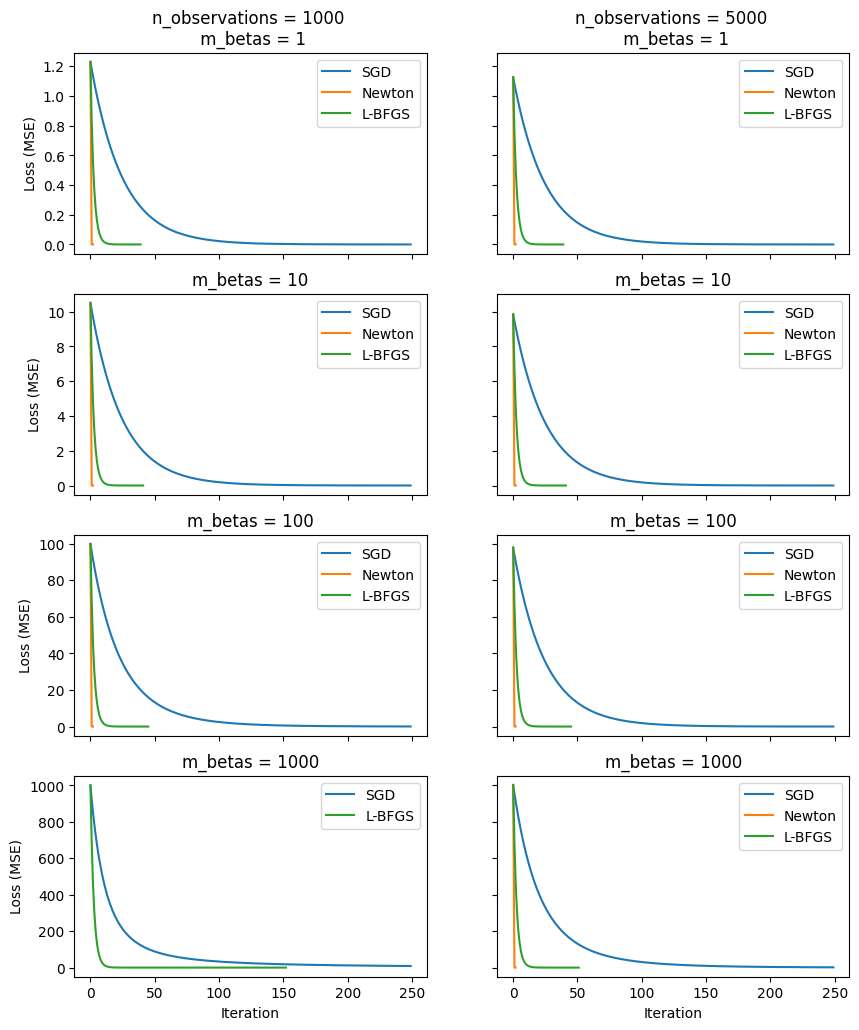

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12), sharex=True, sharey='row')

for i, lh in enumerate([loss_history_1000, loss_history_5000]):

    for j, m in enumerate(ms):
        axes[j][i].plot(np.nanmean(lh['sgd'][j], axis=0), label='SGD')
       
        if i != 0 or j != 3:
            axes[j][i].plot(np.nanmean(lh['newton'][j], axis=0), label='Newton')


        axes[j][i].plot(np.nanmean(lh['lbfgs'][j], axis=0), color='C2', label='L-BFGS')
        
        n_obs = 1000 if i == 0 else 5000

        if i == 0:
            axes[j][i].set_ylabel('Loss (MSE)')
            
        if j == 3:
            axes[j][i].set_xlabel('Iteration')
            
        if j == 0:
            title = f'n_observations = {n_obs} \n m_betas = {m}'
        else:
            title = f'm_betas = {m}'
            
        axes[j][i].set_title(title)
        
        axes[j][i].legend();
        
        
plt.savefig('../results/loss.png')

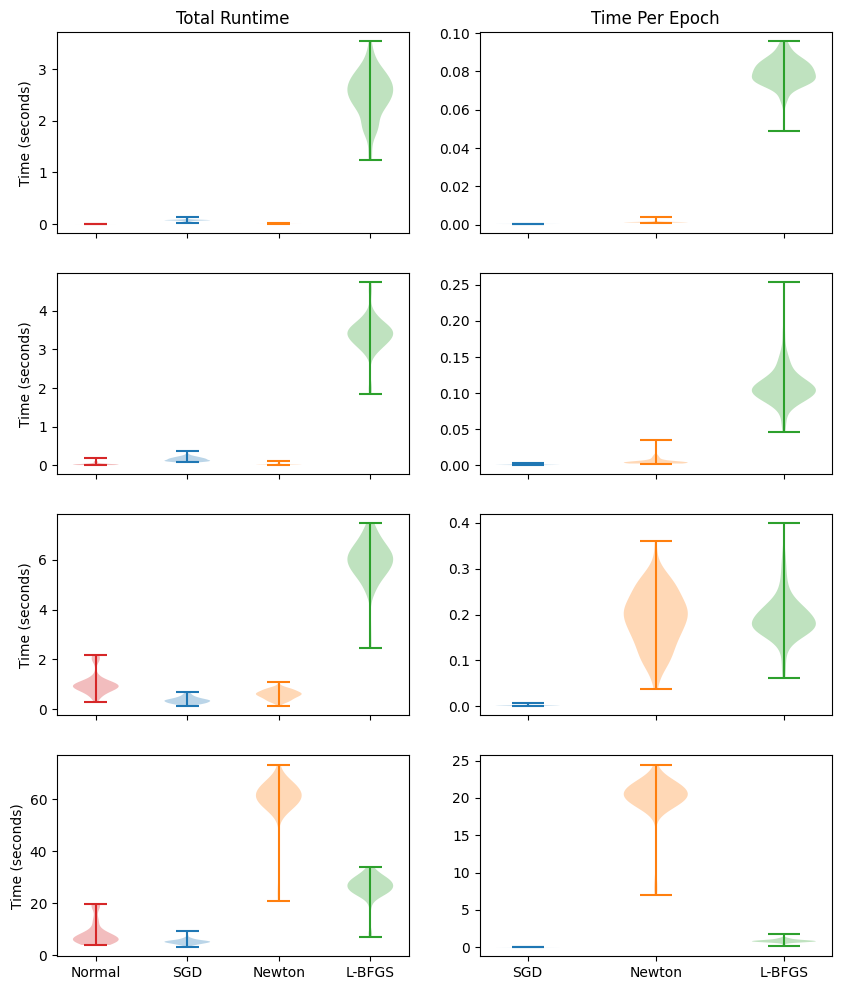

In [6]:
methods = ['sgd', 'newton', 'lbfgs']

fig, axes = plt.subplots(ncols=2, nrows=len(ms), figsize=(10, 12), sharex='col')

for i_m, m in enumerate(ms):
    
    for j_m, method in enumerate(methods):
        
        n_iterations = np.zeros(n_sim)

        for ind, i in enumerate(np.isnan(loss_history_5000[method][0])):

            inds = np.where(i)[0]

            if len(inds) == 0:
                n_iterations[ind] = 250
            else:
                n_iterations[ind] = inds[0]

            elapsed_time_5000[method][i_m]

        time_per_iter = (elapsed_time_5000[method][i_m] / n_iterations) 
        
        axes[i_m][1].violinplot(time_per_iter, positions=[j_m+1])

    
for i_m, m in enumerate(ms):
    axes[i_m][0].violinplot(elapsed_time_5000['sgd'][i_m], positions=[2])
    axes[i_m][0].violinplot(elapsed_time_5000['newton'][i_m], positions=[3])
    axes[i_m][0].violinplot(elapsed_time_5000['lbfgs'][i_m], positions=[4])
    axes[i_m][0].violinplot(elapsed_time_5000['normal'][i_m], positions=[1])
    

axes[0][0].set_title('Total Runtime')
axes[0][1].set_title('Time Per Epoch')

axes[3][0].set_xticks([1, 2, 3, 4])
axes[3][0].set_xticklabels(labels=['Normal', 'SGD', 'Newton', 'L-BFGS'])

axes[3][1].set_xticks([1, 2, 3])
axes[3][1].set_xticklabels(labels=['SGD', 'Newton', 'L-BFGS'])

for ax in axes:
    ax[0].set_ylabel('Time (seconds)')
    
plt.savefig('../results/time.png')

/home/rphammonds/projects/dsc210/.env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/rphammonds/projects/dsc210/.env/lib/python3.10/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


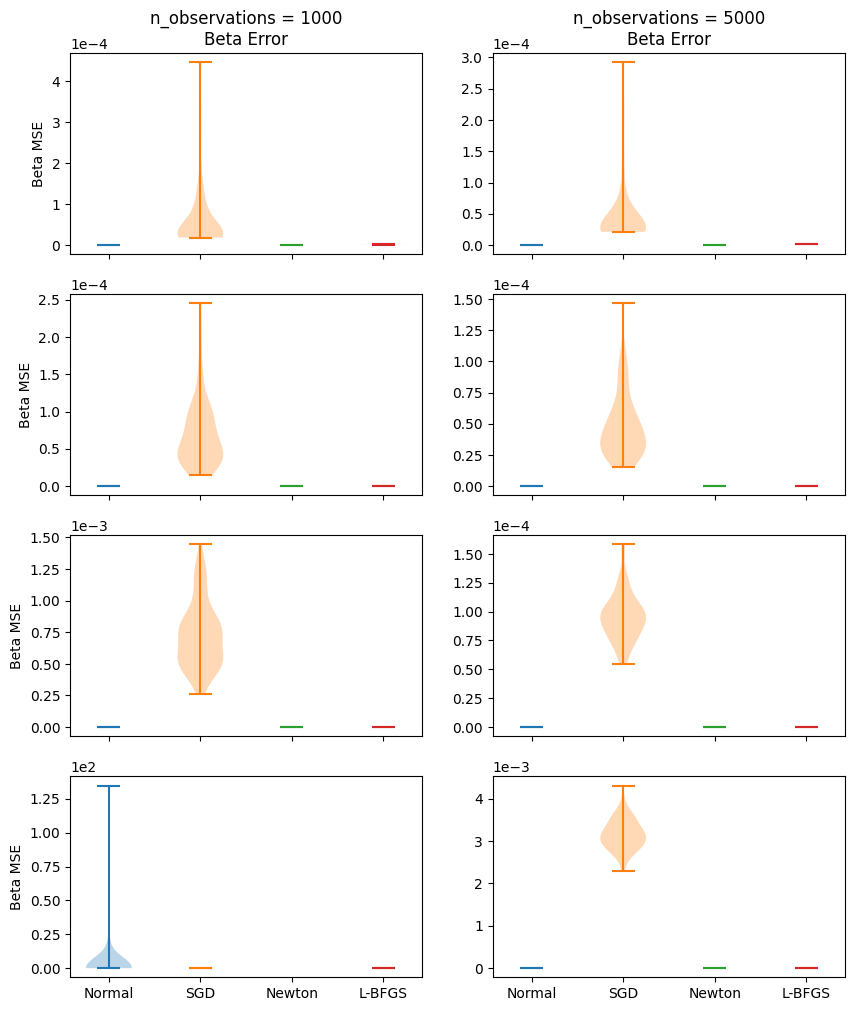

In [7]:
methods = ['normal', 'sgd', 'newton', 'lbfgs']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12), sharex=True)

for i, bh in enumerate([beta_mse_1000, beta_mse_5000]):
    
    
    for j, m in enumerate(ms):
        

        for k, method in enumerate(methods):
            
            if method == 'newton'and i == 1:
                # remove nans
                betas = bh['newton'][j][np.isfinite(bh['newton'][k])]
            else:
                betas = bh[method][j]
                
            axes[j][i].violinplot(betas, positions=[k])
            
for ax in axes:
    for _ax in ax:
        _ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 1))
        
axes[3][0].set_xticks([0, 1, 2, 3])
axes[3][0].set_xticklabels(labels=['Normal', 'SGD', 'Newton', 'L-BFGS'])

axes[0][0].set_title(f'n_observations = 1000\nBeta Error')
axes[0][1].set_title(f'n_observations = 5000\nBeta Error')

for i in range(4):
    axes[i][0].set_ylabel('Beta MSE')
    
plt.savefig('../results/beta_error.png')